In [169]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [170]:
import metbio1dnet
model = metbio1dnet.MetaBioClassifier1D()

model.load_weights('../models/1dcnn_model.weights.h5')

In [171]:
X_train = pd.read_csv('../analysis/X_train.csv')
Y_train = pd.read_csv('../analysis/Y_train.csv')
X_test = pd.read_csv('../analysis/X_test.csv')
Y_test = pd.read_csv('../analysis/Y_test.csv')

In [172]:
X_train_array = X_train.to_numpy()
Y_train = Y_train.to_numpy
X_test_array = X_test.to_numpy()
Y_test = Y_test.to_numpy

## Using Permuations

In [173]:
explainer_p = shap.explainers.Permutation(model.predict, X_test)
shap_values_p = explainer_p(X_test)

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
232/232 ━━━━━━━

PermutationExplainer explainer:  54%|█████▍    | 19/35 [00:00<?, ?it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


PermutationExplainer explainer:  60%|██████    | 21/35 [00:10<00:03,  3.99it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step


PermutationExplainer explainer:  63%|██████▎   | 22/35 [00:11<00:04,  2.73it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


PermutationExplainer explainer:  66%|██████▌   | 23/35 [00:12<00:05,  2.37it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  69%|██████▊   | 24/35 [00:12<00:05,  2.16it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


PermutationExplainer explainer:  71%|███████▏  | 25/35 [00:13<00:04,  2.11it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


PermutationExplainer explainer:  74%|███████▍  | 26/35 [00:13<00:04,  2.06it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  77%|███████▋  | 27/35 [00:14<00:04,  1.89it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


PermutationExplainer explainer:  80%|████████  | 28/35 [00:14<00:03,  1.91it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


PermutationExplainer explainer:  83%|████████▎ | 29/35 [00:15<00:03,  1.93it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


PermutationExplainer explainer:  86%|████████▌ | 30/35 [00:15<00:02,  1.94it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


PermutationExplainer explainer:  89%|████████▊ | 31/35 [00:16<00:02,  1.96it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step


PermutationExplainer explainer:  91%|█████████▏| 32/35 [00:16<00:01,  1.90it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


PermutationExplainer explainer:  94%|█████████▍| 33/35 [00:17<00:01,  1.92it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


PermutationExplainer explainer:  97%|█████████▋| 34/35 [00:17<00:00,  1.96it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


PermutationExplainer explainer: 100%|██████████| 35/35 [00:18<00:00,  1.96it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


PermutationExplainer explainer: 36it [00:18,  1.10s/it]                        


In [192]:
metabolite_names = X_test.columns
metabolite_names

Index(['Age', 'Creatinine', 'Glycine', 'Alanine', 'Serine', 'Proline',
       'Valine', 'Threonine', 'Taurine', 'Putrescine',
       ...
       'Decadienoylcarnitine', 'Decenoylcarnitine', 'Decanoylcarnitine',
       'Dodecenoylcarnitine', 'Dodecanoylcarnitine', 'Hexadecanoylcarnitine',
       'Octadecadienylcarnitine', 'Octadecenoylcarnitine', 'Sex_Female',
       'Sex_Male'],
      dtype='object', length=110)

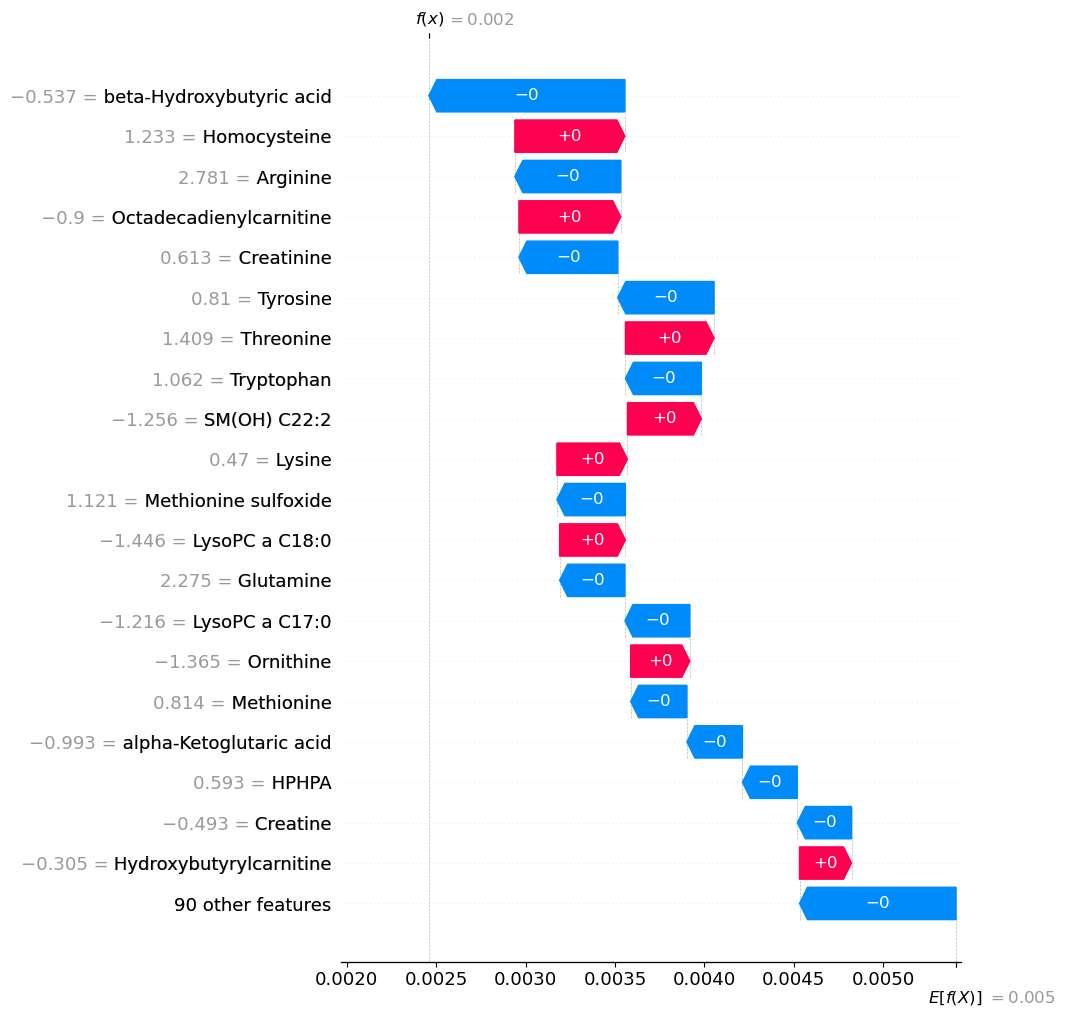

In [248]:
explanation_p = shap.Explanation(shap_values_p[0, :, 0], feature_names=metabolite_names)
shap.waterfall_plot(explanation_p, max_display=21)

In [261]:
# Sort the SHAP values by absolute value in descending order
sorted_shap_values = sorted(zip(explanation_p.feature_names, explanation_p.values.ravel()), 
                           key=lambda x: abs(x[1]), reverse=True)

# Create a DataFrame from the top 20 features
top_metabolites = pd.DataFrame({
    'Metabolite': [feature for feature, _ in sorted_shap_values[:20]],
    'SHAP Value': [value for _, value in sorted_shap_values[:20]]
})

print(top_metabolites)

                  Metabolite  SHAP Value
0   beta-Hydroxybutyric acid   -0.001096
1               Homocysteine    0.000615
2                   Arginine   -0.000592
3    Octadecadienylcarnitine    0.000570
4                 Creatinine   -0.000553
5                   Tyrosine   -0.000539
6                  Threonine    0.000496
7                 Tryptophan   -0.000425
8               SM(OH) C22:2    0.000414
9                     Lysine    0.000395
10      Methionine sulfoxide   -0.000383
11            LysoPC a C18:0    0.000368
12                 Glutamine   -0.000365
13            LysoPC a C17:0   -0.000363
14                 Ornithine    0.000331
15                Methionine   -0.000314
16   alpha-Ketoglutaric acid   -0.000311
17                     HPHPA   -0.000307
18                  Creatine   -0.000303
19   Hydroxybutyrylcarnitine    0.000291


In [251]:
shap_values_control = np.array(shap_values_p[..., 0].values)
shap_values_covid = np.array(shap_values_p[..., 1].values)

In [254]:
# SHAP values contain importance across all test samples
shap_values_control.shape

(35, 110)

In [256]:
# Compute the mean absolute SHAP values for each metabolite across all samples
mean_shap_control = np.mean(np.abs(shap_values_control), axis=0)
mean_shap_covid = np.mean(np.abs(shap_values_covid), axis=0)

In [257]:
# Create DataFrames for better visualization of SHAP values
df_shap_control = pd.DataFrame({'metabolite': metabolite_names, 'mean_abs_shap': mean_shap_control})
df_shap_covid = pd.DataFrame({'metabolite': metabolite_names, 'mean_abs_shap': mean_shap_covid})

In [263]:
# Filter both control and covid shap frames for top metabolites
df_shap_control_filtered = df_shap_control[df_shap_control['metabolite'].isin(list(top_metabolites['Metabolite']))]
df_shap_covid_filtered = df_shap_covid[df_shap_covid['metabolite'].isin(list(top_metabolites['Metabolite']))]

In [268]:
df_combined = pd.DataFrame({
    'Metabolite': df_shap_control_filtered['metabolite'],  # Metabolites are the same across groups
    'Control': df_shap_control_filtered['mean_abs_shap'],
    'Covid': df_shap_covid_filtered['mean_abs_shap']
})

# Melt the DataFrame into long format
df_long = pd.melt(df_combined, id_vars='Metabolite', 
                  value_vars=['Control', 'Covid'], 
                  var_name='Group', value_name='SHAP Value')

# Sort metabolites by SHAP value for better visualization (optional)
df_long['Metabolite'] = pd.Categorical(df_long['Metabolite'], categories=df_combined['Metabolite'], ordered=True)

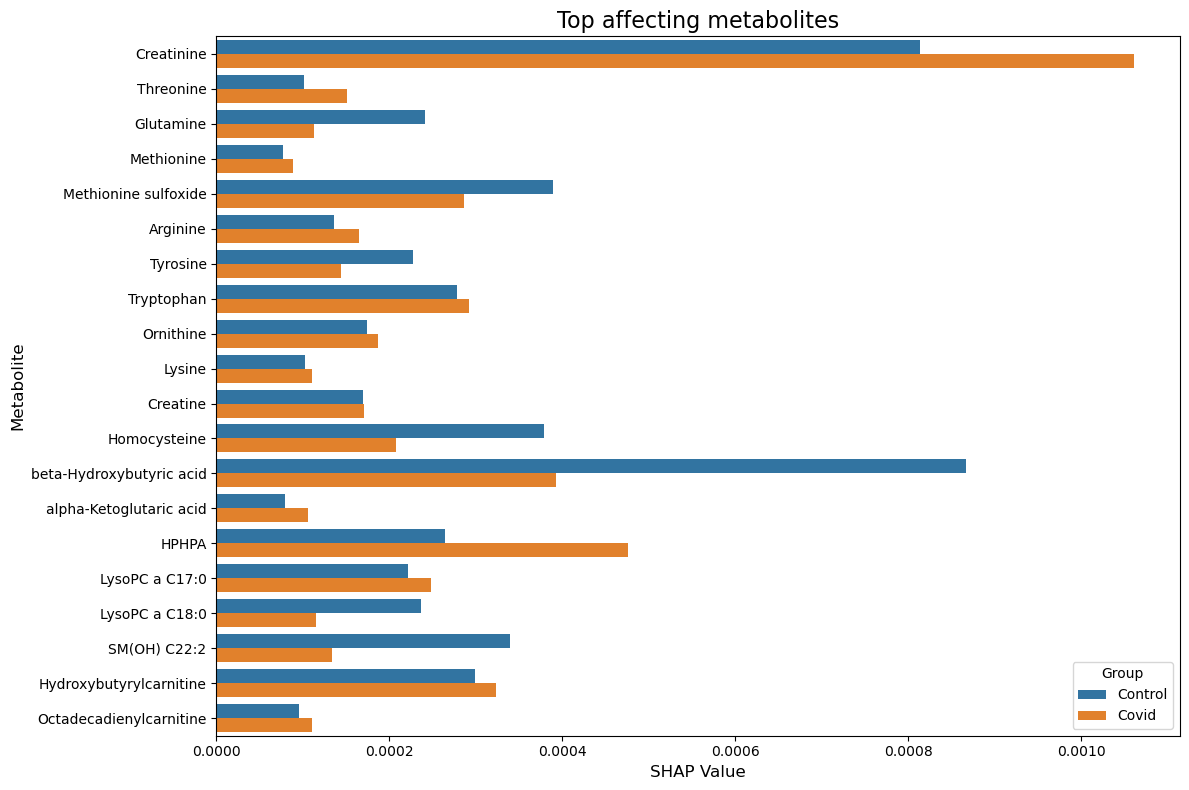

In [270]:
# Create the grouped bar chart using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=df_long, y='Metabolite', x='SHAP Value', hue='Group')

# Add titles and labels
plt.title('Top affecting metabolites', fontsize=16)
plt.xlabel('SHAP Value', fontsize=12)
plt.ylabel('Metabolite', fontsize=12)
plt.legend(title='Group')

# Adjust layout for better readability
plt.tight_layout()
plt.show()